# Ground Zero

## Packages and Datasets

In [70]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'researchpy', 'missingno', 'folium', 'pydotplus' }
missing = required - installedPackages
if missing:
    !pip install researchpy
    !pip install missingno
    !pip install folium
    !pip install pydotplus

  Using cached pydotplus-2.0.2.tar.gz (278 kB)
  Created wheel for pydotplus: filename=pydotplus-2.0.2-py3-none-any.whl size=24572 sha256=8164d2c6effca91ac569ba597a229955373e8408ddb779a4b418a05bb3afbc90
  Stored in directory: c:\users\shirin\appdata\local\pip\cache\wheels\fe\cd\78\a7e873cc049759194f8271f780640cf96b35e5a48bef0e2f36
Successfully built pydotplus


In [3]:
#Disable the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
import timeit
start_time = timeit.default_timer()  #timestamp to calculate total runtime

import pandas as pd
import numpy as np

import researchpy as rp
import missingno as msno

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import scipy.stats as ss

import folium
from folium import plugins

from sklearn.model_selection import train_test_split
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

%matplotlib inline
pd.set_option('display.max_columns', None)  # prevent column output trancation
sns.set()  # change plot styling from Matlab's 90s feel to today's Seaborn.

In [5]:
# File Directories
path_crashes = '../crashes.sample2020.csv'
path_vehicles = '../vehicles.sample.csv'
path_people = '../people.sample.csv'

# Import samples
crashes = pd.read_csv(
    path_crashes,
    parse_dates=["CRASH_DATE", "CRASH_DATE_EST_I", "DATE_POLICE_NOTIFIED"],
    low_memory=False,
    dtype=object)

vehicles = pd.read_csv(path_vehicles,
                       parse_dates=["CRASH_DATE"],
                       low_memory=False,
                       dtype=object)

people = pd.read_csv(path_people,
                     parse_dates=["CRASH_DATE"],
                     low_memory=False,
                     dtype=object)

## Overview of Sprint 2
- Understanding of Feature Processes
- Data Merge & Split
- Feature Reduction & Missing Value Treatment
- Outliers
- Feature Engineering
- Baseline Model

## Our Understanding

### Feature Engineering Process

[Source](https://en.wikipedia.org/wiki/Feature_engineering)

The feature engineering process is:
- Brainstorming or testing features;
- Deciding what features to create;
- Creating features;
- Checking how the features work with your model;
- **Improving your features if needed;**
- Go back to brainstorming/creating more features until the work is done.

### Some Terms

[Source](https://datascience.stackexchange.com/questions/29006/feature-selection-vs-feature-extraction-which-to-use-when)

**Feature Extraction and Feature Engineering:** transformation of raw data into features suitable for modeling; 

- Texts(ngrams, word2vec, tf-idf etc)
- Geospatial data(lat, long)
- Date and time(day, month, week, year, rolling based)
- Time series, web, etc
- Dimensional Reduction Techniques (PCA, SVD, Eigen-Faces etc)
- Clustering (DBSCAN etc)
- And others.

---

**Feature / Data Transformation:** transformation of data to improve the accuracy of the algorithm;
- Normalization and changing distribution(Scaling)
- Interactions
- Handling missing Values
- Handling outliers
- Handling time-date / mixed variables
- Encoding categorical features
- Variable types 
- And others.

---

**Feature Selection:** removing unnecessary features.

- Statistical approaches
- Selection by modeling
- Grid search
- Cross Validation
- And others

---

For the purpose of workflow, we will split **Feature Selection** into; 
- **feature reduction** to remove unnecessary features, 
- and **feature selection** to select features by their importance scores through ML/statistical techniques.

# Data Merge & Split

## Merging datasets

The goal is to successfully merge all datasets by increasing crash records as little as possible.

In [6]:
print("Here is the initial shape of the three datasets:")
print("Crashes", crashes.shape)
print("Vehicles", vehicles.shape)
print("People", people.shape)

Here is the initial shape of the three datasets:
Crashes (33408, 49)
Vehicles (75673, 72)
People (82049, 30)


**Data Merge Strategy**

- Filter out passengers from **`people`**, and left-join it to **`vehicles`** on `CRASH_RECORD_ID`, `RD_NO`, `CRASH_DATE`, `VEHICLE_ID`.

- Then inner-join this dataset to **`crashes`** on `CRASH_RECORD_ID`, `RD_NO`, `CRASH_DATE`.

---

**Reasoning**

- `people` has **many-to-one relationship** with `vehicles` but a pedestrian in `vehicles` has **one-to-one** with `people`,

- Passengers don't have <u>a trajectory separate from the unit</u> they belong to and they don't contribute to accidents with their existence but they are involved if they got harmed through `injuries` features,

- This method increases `crashes` records **only per active parties involved**.

In [7]:
# Filter only non-pessenger people (drivers, pedestrian, cyclist, etc.)
non_passengers = people[people.PERSON_ID.str.contains('^O')]

In [8]:
# Left join non-peseenger people with vehicles
vehicles_with_people = vehicles.merge(non_passengers, 
                                      how='left', 
                                      on=['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE', 'VEHICLE_ID'])
vehicles_with_people.head()

,CRASH_UNIT_ID,CRASH_RECORD_ID,RD_NO,CRASH_DATE,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS,PERSON_ID,PERSON_TYPE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,228894,2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...,JA453603,2017-10-01 02:20:00,1,DRIVER,NaN,224185,NaN,DODGE,CHARGER,IL,2012,UNKNOWN,PASSENGER,PERSONAL,N,STRAIGHT AHEAD,Y,NaN,1,NaN,PRIVATE TOW,UNKNOWN,NaN,Y,Y,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,FRONT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O228894,DRIVER,NaN,KANKAKKE,IL,60901,M,18,IL,D,SAFETY BELT USED,"DEPLOYED, FRONT",NONE,NONINCAPACITATING INJURY,NaN,NaN,NaN,UNKNOWN,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,228895,2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...,JA453603,2017-10-01 02:20:00,2,PARKED,NaN,224187,NaN,GENERAL MOTORS CORP.,YUKON,IL,2003,UNKNOWN,PASSENGER,PERSONAL,N,PARKED,Y,NaN,0,NaN,PRIVATE TOW,UNKNOWN,N,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,228896,2524b06fc6634bd349fc1d7f132c8362529473768f6ac2...,JA453603,2017-10-01 02:20:00,3,PARKED,NaN,224191,NaN,SATURN,UNKNOWN,IL,2000,UNKNOWN,PASSENGER,PERSONAL,N,PARKED,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REAR-RIGHT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,228905,f7210aec9ac43a7b36c30b49033adebcb3060b96580341...,JA453640,2017-10-01 02:41:00,1,DRIVER,NaN,224199,NaN,FORD,WINDSTAR,IL,2007,NONE,VAN/MINI-VAN,PERSONAL,E,STRAIGHT AHEAD,Y,NaN,1,NaN,NaN,NaN,NaN,Y,Y,Y,Y,NaN,N,N,N,NaN,NaN,Y,NaN,NaN,TOTAL (ALL AREAS),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O228905,DRIVER,NaN,CHICAGO,IL,60632,M,43,IL,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,IMPROPER LANE CHANGE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
4,228906,f7210aec9ac43a7b36c30b49033adebcb3060b96580341...,JA453640,2017-10-01 02:41:00,2,DRIVERLESS,NaN,224203,NaN,CHEVROLET,CRUZE,IL,2012,NONE,PASSENGER,NOT IN USE,UNKNOWN,PARKED,Y,NaN,0,NaN,NaN,NaN,NaN,Y,Y,NaN,NaN,NaN,Y,Y,Y,NaN,NaN,Y,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print("Shape of vehicles with people", vehicles_with_people.shape)

Shape of vehicles with people (75838, 98)


In [10]:
merged_data = crashes.merge(vehicles_with_people, 
                            how='inner', 
                            on=['CRASH_RECORD_ID', 'RD_NO', 'CRASH_DATE'])

print('Dimensions of the data after merging', merged_data.shape)

Dimensions of the data after merging (68503, 144)


**Inspection 1**

In [11]:
merged_data.groupby('CRASH_RECORD_ID').head()

,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_UNIT_ID,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS,PERSON_ID,PERSON_TYPE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667550,1,DRIVER,NaN,635502,NaN,CHEVROLET,EQUINOX,IL,2017,UNKNOWN,SPORT UTILITY VEHICLE (SUV),UNKNOWN/NA,W,STRAIGHT AHEAD,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667550,DRIVER,NaN,HOMEWOOD,IL,60430,F,56,IL,D,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667551,2,DRIVER,1,635496,NaN,CHEVROLET,SILVERADO,IL,2016,NONE,PICKUP,PERSONAL,W,STARTING IN TRAFFIC,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667551,DRIVER,NaN,PALOS HILLS,IL,60465,M,51,IL,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST 

**Inspection 2**

In [12]:
print("Wrong joins could have resulted in 6 rows. Here we see 2 rows, meaning the join was successful.")
merged_data[merged_data.RD_NO=='JC301403'] #Wrong joins could result in 6 rows

Wrong joins could have resulted in 6 rows. Here we see 2 rows, meaning the join was successful.


,CRASH_RECORD_ID,RD_NO,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,LANE_CNT,ALIGNMENT,ROADWAY_SURFACE_COND,ROAD_DEFECT,REPORT_TYPE,CRASH_TYPE,INTERSECTION_RELATED_I,NOT_RIGHT_OF_WAY_I,HIT_AND_RUN_I,DAMAGE,DATE_POLICE_NOTIFIED,PRIM_CONTRIBUTORY_CAUSE,SEC_CONTRIBUTORY_CAUSE,STREET_NO,STREET_DIRECTION,STREET_NAME,BEAT_OF_OCCURRENCE,PHOTOS_TAKEN_I,STATEMENTS_TAKEN_I,DOORING_I,WORK_ZONE_I,WORK_ZONE_TYPE,WORKERS_PRESENT_I,NUM_UNITS,MOST_SEVERE_INJURY,INJURIES_TOTAL,INJURIES_FATAL,INJURIES_INCAPACITATING,INJURIES_NON_INCAPACITATING,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,INJURIES_UNKNOWN,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,LOCATION,CRASH_UNIT_ID,UNIT_NO,UNIT_TYPE,NUM_PASSENGERS,VEHICLE_ID,CMRC_VEH_I,MAKE,MODEL,LIC_PLATE_STATE,VEHICLE_YEAR,VEHICLE_DEFECT,VEHICLE_TYPE,VEHICLE_USE,TRAVEL_DIRECTION,MANEUVER,TOWED_I,FIRE_I,OCCUPANT_CNT,EXCEED_SPEED_LIMIT_I,TOWED_BY,TOWED_TO,AREA_00_I,AREA_01_I,AREA_02_I,AREA_03_I,AREA_04_I,AREA_05_I,AREA_06_I,AREA_07_I,AREA_08_I,AREA_09_I,AREA_10_I,AREA_11_I,AREA_12_I,AREA_99_I,FIRST_CONTACT_POINT,CMV_ID,USDOT_NO,CCMC_NO,ILCC_NO,COMMERCIAL_SRC,GVWR,CARRIER_NAME,CARRIER_STATE,CARRIER_CITY,HAZMAT_PLACARDS_I,HAZMAT_NAME,UN_NO,HAZMAT_PRESENT_I,HAZMAT_REPORT_I,HAZMAT_REPORT_NO,MCS_REPORT_I,MCS_REPORT_NO,HAZMAT_VIO_CAUSE_CRASH_I,MCS_VIO_CAUSE_CRASH_I,IDOT_PERMIT_NO,WIDE_LOAD_I,TRAILER1_WIDTH,TRAILER2_WIDTH,TRAILER1_LENGTH,TRAILER2_LENGTH,TOTAL_VEHICLE_LENGTH,AXLE_CNT,VEHICLE_CONFIG,CARGO_BODY_TYPE,LOAD_TYPE,HAZMAT_OUT_OF_SERVICE_I,MCS_OUT_OF_SERVICE_I,HAZMAT_CLASS,PERSON_ID,PERSON_TYPE,SEAT_NO,CITY,STATE,ZIPCODE,SEX,AGE,DRIVERS_LICENSE_STATE,DRIVERS_LICENSE_CLASS,SAFETY_EQUIPMENT,AIRBAG_DEPLOYED,EJECTION,INJURY_CLASSIFICATION,HOSPITAL,EMS_AGENCY,EMS_RUN_NO,DRIVER_ACTION,DRIVER_VISION,PHYSICAL_CONDITION,PEDPEDAL_ACTION,PEDPEDAL_VISIBILITY,PEDPEDAL_LOCATION,BAC_RESULT,BAC_RESULT VALUE,CELL_PHONE_USE
0,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667550,1,DRIVER,NaN,635502,NaN,CHEVROLET,EQUINOX,IL,2017,UNKNOWN,SPORT UTILITY VEHICLE (SUV),UNKNOWN/NA,W,STRAIGHT AHEAD,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,OTHER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667550,DRIVER,NaN,HOMEWOOD,IL,60430,F,56,IL,D,USAGE UNKNOWN,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,UNKNOWN,UNKNOWN,NORMAL,NaN,NaN,NaN,TEST NOT OFFERED,NaN,NaN
1,0211e1f766f3940dfa87375661d25b716655e908c320cc...,JC301403,NaN,2019-06-11 08:40:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN BARRIER,NaN,STRAIGHT AND LEVEL,DRY,NO DEFECTS,NOT ON SCENE (DESK REPORT),NO INJURY / DRIVE AWAY,Y,NaN,NaN,"$501 - $1,500",2019-06-11 09:05:00,UNABLE TO DETERMINE,NOT APPLICABLE,50,E,GARFIELD BLVD,225,NaN,NaN,NaN,NaN,NaN,NaN,2,NO INDICATION OF INJURY,0,0,0,0,0,3,0,8,3,6,41.794778764,-87.623828038,POINT (-87.623828038036 41.794778764028),667551,2,DRIVER,1,635496,NaN,CHEVROLET,SILVERADO,IL,2016,NONE,PICKUP,PERSONAL,W,STARTING IN TRAFFIC,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,NaN,NaN,NaN,NaN,NaN,NaN,NaN,REAR-LEFT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,O667551,DRIVER,NaN,PALOS HILLS,IL,60465,M,51,IL,D,SAFETY BELT USED,DID NOT DEPLOY,NONE,NO INDICATION OF INJURY,NaN,NaN,NaN,NONE,NOT OBSCURED,NORMAL,NaN,NaN,NaN,TEST 

## Splitting the data

In [13]:
# Alternative: X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
raw_train, raw_test = train_test_split(merged_data, test_size=0.20, random_state=42, shuffle=True)

In [14]:
print("Train shape", raw_train.shape)
print("Test shape", raw_test.shape)

Train shape (54802, 144)
Test shape (13701, 144)


**Write datasets as csv**

In [15]:
# save the train and test file
#train.to_csv('~/repos/vision_zero_chicago_project/sprint 2/raw_train.csv')
#test.to_csv('~/repos/vision_zero_chicago_project/sprint 2/raw_test.csv')

# Feature Reduction

## Detailed look at all features

In [16]:
raw_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54802 entries, 29244 to 15795
Columns: 144 entries, CRASH_RECORD_ID to CELL_PHONE_USE
dtypes: datetime64[ns](2), object(142)
memory usage: 60.6+ MB


| **Feature** | **Description** | **Decision to drop** |
|:-----|:----:|----:|
| CRASH_RECORD_ID | This number can be used to link to the same crash in the Vehicles and People datasets. This number also serves as a unique ID in this dataset. | NO |
| RD_NO | Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes. | YES |
| CRASH_DATE_EST_I | Crash date estimated by desk officer or reporting party (only used in cases where crash is reported at police station days after the crash) | YES |
| CRASH_DATE | Date and time of crash as entered by the reporting officer | NO |
| POSTED_SPEED_LIMIT | Posted speed limit, as determined by reporting officer | NO |
| TRAFFIC_CONTROL_DEVICE | Traffic control device present at crash location, as determined by reporting officer | NO |
| DEVICE_CONDITION | Condition of traffic control device, as determined by reporting officer | NO |
| WEATHER_CONDITION | Weather condition at time of crash, as determined by reporting officer | NO |
| LIGHTING_CONDITION | Light condition at time of crash, as determined by reporting officer | NO |
| FIRST_CRASH_TYPE | Type of first collision in crash | NO |
| TRAFFICWAY_TYPE | Trafficway type, as determined by reporting officer | NO |
| LANE_CNT | Total number of through lanes in either direction, excluding turn lanes, as determined by reporting officer (0 = intersection) | NO |
| ALIGNMENT | Street alignment at crash location, as determined by reporting officer | NO |
| ROADWAY_SURFACE_COND | Road surface condition, as determined by reporting officer | NO |
| ROAD_DEFECT | Road defects, as determined by reporting officer | NO |
| REPORT_TYPE | Administrative report type (at scene, at desk, amended) | YES |
| CRASH_TYPE | A general severity classification for the crash. Can be either Injury and/or Tow Due to Crash or No Injury / Drive Away | NO |
| INTERSECTION_RELATED_I |A field observation by the police officer whether an intersection played a role in the crash. Does not represent whether or not the crash occurred within the intersection. | NO |
| NOT_RIGHT_OF_WAY_I | Whether the crash begun or first contact was made outside of the public right-of-way. | NO |
| HIT_AND_RUN_I | Crash did/did not involve a driver who caused the crash and fled the scene without exchanging information and/or rendering aid | NO |
| DAMAGE | A field observation of estimated damage. | NO |
| DATE_POLICE_NOTIFIED | Calendar date on which police were notified of the crash | YES |
| PRIM_CONTRIBUTORY_CAUSE | The factor which was most significant in causing the crash, as determined by officer judgment | NO |
| SEC_CONTRIBUTORY_CAUSE | The factor which was second most significant in causing the crash, as determined by officer judgment | NO |
| STREET_NO | Street address number of crash location, as determined by reporting officer | NO |
| STREET_DIRECTION | Street address direction (N,E,S,W) of crash location, as determined by reporting officer | NO |
| STREET_NAME | Street address name of crash location, as determined by reporting officer | NO |
| BEAT_OF_OCCURRENCE | Chicago Police Department Beat ID | YES |
| PHOTOS_TAKEN_I | Whether the Chicago Police Department took photos at the location of the crash | YES |
| STATEMENTS_TAKEN_I | Whether statements were taken from unit(s) involved in crash | YES |
| DOORING_I | Whether crash involved a motor vehicle occupant opening a door into the travel path of a bicyclist, causing a crash | NO |
| WORK_ZONE_I | Whether the crash occurred in an active work zone | NO |
| WORK_ZONE_TYPE | The type of work zone, if any | YES |
| WORKERS_PRESENT_I | Whether construction workers were present in an active work zone at crash location | YES |
| NUM_UNITS | Number of units involved in the crash. A unit can be a motor vehicle, a pedestrian, a bicyclist, or another non-passenger roadway user. Each unit represents a mode of traffic with an independent trajectory. | NO |
| MOST_SEVERE_INJURY | Most severe injury sustained by any person involved in the crash | NO |
| INJURIES_TOTAL | Total persons sustaining fatal, incapacitating, non-incapacitating, and possible injuries as determined by the reporting officer | NO |
| INJURIES_FATAL | Total persons sustaining fatal injuries in the crash | NO |
| INJURIES_INCAPACITATING | Total persons sustaining incapacitating/serious injuries in the crash as determined by the reporting officer. Any injury other than fatal injury, which prevents the injured person from walking, driving, or normally continuing the activities they were capable of performing before the injury occurred. Includes severe lacerations, broken limbs, skull or chest injuries, and abdominal injuries. | NO |
| INJURIES_NON_INCAPACITATING | Total persons sustaining non-incapacitating injuries in the crash as determined by the reporting officer. Any injury, other than fatal or incapacitating injury, which is evident to observers at the scene of the crash. Includes lump on head, abrasions, bruises, and minor lacerations. | NO |
| INJURIES_REPORTED_NOT_EVIDENT | Total persons sustaining possible injuries in the crash as determined by the reporting officer. Includes momentary unconsciousness, claims of injuries not evident, limping, complaint of pain, nausea, and hysteria. | NO |
| INJURIES_NO_INDICATION | Total persons sustaining no injuries in the crash as determined by the reporting officer | YES |
| INJURIES_UNKNOWN | Total persons for whom injuries sustained, if any, are unknown | YES |
| CRASH_HOUR | The hour of the day component of CRASH_DATE. | NO |
| CRASH_DAY_OF_WEEK | The day of the week component of CRASH_DATE. Sunday=1 | YES |
| CRASH_MONTH | The month component of CRASH_DATE. | YES |
| LATITUDE | The latitude of the crash location, as determined by reporting officer, as derived from the reported address of crash | NO |
| LONGITUDE | The longitude of the crash location, as determined by reporting officer, as derived from the reported address of crash | NO |
| LOCATION | The crash location, as determined by reporting officer, as derived from the reported address of crash, in a column type that allows for mapping and other geographic analysis in the data portal software | YES || PERSON_ID | A unique identifier for each person record. IDs starting with P indicate passengers. IDs starting with O indicate a person who was not a passenger in the vehicle (e.g., driver, pedestrian, cyclist, etc.). | NO |
| PERSON_TYPE | Type of roadway user involved in crash | NO |
| CRASH_RECORD_ID | This number can be used to link to the same crash in the Crashes and Vehicles datasets. This number also serves as a unique ID in the Crashes dataset. | NO |
| RD_NO | Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes. | YES |
| VEHICLE_ID | The corresponding CRASH_UNIT_ID from the Vehicles dataset. | YES |
| CRASH_DATE | Date and time of crash as entered by the reporting officer | YES |
| SEAT_NO | Code for seating position of motor vehicle occupant: 1= driver, 2= center front, 3 = front passenger, 4 = second row left, 5 = second row center, 6 = second row right, 7 = enclosed passengers, 8 = exposed passengers, 9= unknown position, 10 = third row left, 11 = third row center, 12 = third row right | YES |
| CITY | City of residence of person involved in crash | NO |
| STATE | State of residence of person involved in crash | YES |
| ZIPCODE | ZIP Code of residence of person involved in crash | YES |
| SEX | Gender of person involved in crash, as determined by reporting officer | NO |
| AGE | Age of person involved in crash | NO |
| DRIVERS_LICENSE_STATE | State issuing driver's license of person involved in crash | YES |
| DRIVERS_LICENSE_CLASS| Class of driver's license of person involved in crash | YES |
| SAFETY_EQUIPMENT | Safety equipment used by vehicle occupant in crash, if any | NO |
| AIRBAG_DEPLOYED | Whether vehicle occupant airbag deployed as result of crash | NO |
| EJECTION | Whether vehicle occupant was ejected or extricated from the vehicle as a result of crash | NO |
| INJURY_CLASSIFICATION | Severity of injury person sustained in the crash | YES |
| HOSPITAL | Hospital to which person injured in the crash was taken | YES |
| EMS_AGENCY | EMS agency who transported person injured in crash to the hospital | YES |
| EMS_RUN_NO | EMS agency run number | YES |
| DRIVER_ACTION | Driver action that contributed to the crash, as determined by reporting officer | NO |
| DRIVER_VISION | What, if any, objects obscured the driver’s vision at time of crash | NO |
| PHYSICAL_CONDITION | Driver’s apparent physical condition at time of crash, as observed by the reporting officer | NO |
| PEDPEDAL_ACTION | Action of pedestrian or cyclist at the time of crash | NO |
| PEDPEDAL_VISIBILITY | Visibility of pedestrian of cyclist safety equipment in use at time of crash | NO |
| PEDPEDAL_LOCATION | Location of pedestrian or cyclist at the time of crash | YES |
| BAC_RESULT | Status of blood alcohol concentration testing for driver or other person involved in crash | YES |
| BAC_RESULT VALUE | Driver’s blood alcohol concentration test result | NO |
| CELL_PHONE_USE | Whether person was/was not using cellphone at the time of the crash, as determined by the reporting officer | NO |
|CRASH_UNIT_ID | A unique identifier for each vehicle record | YES | 
|CRASH_RECORD_ID | This number can be used to link to the same crash in the Crashes and People datasets. This number also serves as a unique ID in the Crashes dataset | NO | 
|RD_NO | Chicago Police Department report number. For privacy reasons, this column is blank for recent crashes | Yes | 
|CRASH_DATE| Date and time of crash as entered by the reporting officer | No | 
|UNIT_NO| A unique ID for each unit within a specific crash report | Yes | 
|UNIT_TYPE| Type of unit | Yes | 
|NUM_PASSENGERS| Number of passengers in the vehicle. The driver is not included. More information on passengers is in the People dataset | No | 
|VEHICLE_ID| No definition | Yes | 
|CMRC_VEH_I| No definition | Yes | 
|MAKE| The make (brand) of the vehicle, if relevant | YES | 
|MODEL| The model of the vehicle, if relevant| NO | 
|LIC_PLATE_STATE| The state issuing the license plate of the vehicle, if relevant | No | 
|VEHICLE_YEAR| The model year of the vehicle, if relevant | No | 
|VEHICLE_DEFECT| No definition | No | 
|VEHICLE_TYPE| The type of vehicle, if relevant | No | 
|TRAVEL_DIRECTION| The direction in which the unit was traveling prior to the crash, as determined by the reporting officer | No | 
|MANEUVER| The action the unit was taking prior to the crash, as determined by the reporting officer | NO | 
|TOWED_I| Indicator of whether the vehicle was towed | Yes | 
|FIRE_I| No definition | Yes | 
|OCCUPANT_COUNT| The number of people in the unit, as determined by the reporting officer | No | 
|EXCEED_SPEED_LIMIT_I| Indicator of whether the unit was speeding, as determined by the reporting officer | No | 
|TOWED_BY| No definition | Yes | 
|TOWED_TO| No definition | Yes | 
|AREA_00_I:AREA_99_I| No definition | Yes | 
|FIRST_CONTACT_POINT| No definition | No | 
|CMV_ID:HAZMAT_CLASS| No definition | Yes |


**Features to be excluded are**
- `RD_NO`
- `CRASH_DATE_EST_I`
- `REPORT_TYPE`
- `CRASH_DATE_EST_I`
- `REPORT_TYPE`
- `CRASH_TYPE`
- `NOT_RIGHT_OF_WAY_I`
- `DATE_POLICE_NOTIFIED`
- `STREET_DIRECTION`
- `ALIGNMENT`
- `BEAT_OF_OCCURRENCE`
- `PHOTOS_TAKEN_I`
- `STATEMENTS_TAKEN_I`
- `DOORING_I`
- `WORK_ZONE_I`
- `WORK_ZONE_TYPE`
- `WORKERS_PRESENT_I`
- `MOST_SEVERE_INJURY`
- `INJURIES_NO_INDICATION`
- `INJURIES_UNKNOWN`
- `CRASH_DAY_OF_WEEK`
- `CRASH_MONTH`
- `LATITUDE`
- `LONGITUDE`
- `RD_NO`
- `VEHICLE_ID`
- `CRASH_DATE`
- `SEAT_NO`
- `CITY`
- `STATE`
- `ZIPCODE`
- `DRIVERS_LICENSE_STATE`
- `DRIVERS_LICENSE_CLASS`
- `INJURY_CLASSIFICATION`
- `HOSPITAL`
- `EMS_AGENCY`
- `EMS_RUN_NO`
- `PEDPEDAL_ACTION`	
- `PEDPEDAL_VISIBILITY`
- `PEDPEDAL_LOCATION`
- `BAC_RESULT`
- `BAC_RESULT VALUE`
- `CRASH_UNIT_ID`
- `RD_NO`
- `UNIT_NO`
- `UNIT_TYPE`
- `VEHICLE_ID`
- `CMRC_VEH_I`
- `MAKE`
- `MODEL`
- `TOWED_I`
- `FIRE_I`
- `TOWED_BY`
- `TOWED_TO`
- `AREA_00_I`
- `AREA_01_I`
- `AREA_02_I`
- `AREA_03_I`
- `AREA_04_I`
- `AREA_05_I`
- `AREA_06_I`
- `AREA_07_I`
- `AREA_08_I`
- `AREA_09_I`
- `AREA_10_I`
- `AREA_11_I`
- `AREA_12_I`
- `AREA_99_I`
- `CMV_ID:HAZMAT_CLASS`




**Due to the reasons**
- Redundant information
- Non value information (at least for our baseline model)

In [17]:
# Drop the features that are not needed
feature_drop_train = ["CRASH_DATE_EST_I", "REPORT_TYPE", "CRASH_DATE_EST_I", "REPORT_TYPE", 
                      "DATE_POLICE_NOTIFIED","BEAT_OF_OCCURRENCE", "PHOTOS_TAKEN_I", "STATEMENTS_TAKEN_I", 
                      "WORK_ZONE_TYPE", "WORKERS_PRESENT_I","INJURIES_NO_INDICATION", "INJURIES_UNKNOWN",
                      "CRASH_DAY_OF_WEEK", "CRASH_MONTH", "RD_NO", "VEHICLE_ID", "CRASH_RECORD_ID",
                      "CRASH_DATE", "SEAT_NO", "STATE", "ZIPCODE", "DRIVERS_LICENSE_STATE", "PERSON_ID",
                      "DRIVERS_LICENSE_CLASS", "INJURY_CLASSIFICATION", "HOSPITAL", "EMS_AGENCY", 
                      "EMS_RUN_NO", "PEDPEDAL_LOCATION", "LOCATION","DAMAGE","CRASH_TYPE","MODEL",
                      "BAC_RESULT", "CRASH_UNIT_ID", "RD_NO", "UNIT_NO", "UNIT_TYPE", "VEHICLE_ID", 
                      "CMRC_VEH_I", "MAKE", "TOWED_I", "FIRE_I", "TOWED_BY", "STREET_NO","STREET_NAME",
                      "TOWED_TO", "AREA_00_I", "AREA_01_I", "AREA_02_I", "AREA_03_I", "AREA_04_I", 
                      "AREA_05_I", "AREA_06_I", "AREA_07_I", "AREA_08_I", "AREA_09_I", "AREA_10_I", 
                      "AREA_11_I", "AREA_12_I", "AREA_99_I", "CMV_ID", "USDOT_NO", "CCMC_NO", 
                      "ILCC_NO", "COMMERCIAL_SRC", "GVWR", "CARRIER_NAME", "CARRIER_STATE", "CARRIER_CITY",
                      "HAZMAT_PLACARDS_I", "HAZMAT_NAME", "UN_NO", "HAZMAT_PRESENT_I", "HAZMAT_REPORT_I",
                      "HAZMAT_REPORT_NO", "MCS_REPORT_I", "MCS_REPORT_NO", "HAZMAT_VIO_CAUSE_CRASH_I", 
                      "MCS_VIO_CAUSE_CRASH_I", "IDOT_PERMIT_NO", "WIDE_LOAD_I", "TRAILER1_WIDTH", 
                      "TRAILER2_WIDTH", "TRAILER1_LENGTH", "TRAILER2_LENGTH", "TOTAL_VEHICLE_LENGTH",
                      "AXLE_CNT", "VEHICLE_CONFIG", "CARGO_BODY_TYPE", "LOAD_TYPE", "HAZMAT_OUT_OF_SERVICE_I",
                      "INJURIES_FATAL","INJURIES_INCAPACITATING","INJURIES_NON_INCAPACITATING","INJURIES_REPORTED_NOT_EVIDENT",
                      "MCS_OUT_OF_SERVICE_I", "HAZMAT_CLASS"]

train = raw_train.loc[:, ~raw_train.columns.isin(feature_drop_train)]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54802 entries, 29244 to 15795
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   POSTED_SPEED_LIMIT       54802 non-null  object
 1   TRAFFIC_CONTROL_DEVICE   54802 non-null  object
 2   DEVICE_CONDITION         54802 non-null  object
 3   WEATHER_CONDITION        54802 non-null  object
 4   LIGHTING_CONDITION       54802 non-null  object
 5   FIRST_CRASH_TYPE         54802 non-null  object
 6   TRAFFICWAY_TYPE          54802 non-null  object
 7   LANE_CNT                 18076 non-null  object
 8   ALIGNMENT                54802 non-null  object
 9   ROADWAY_SURFACE_COND     54802 non-null  object
 10  ROAD_DEFECT              54802 non-null  object
 11  INTERSECTION_RELATED_I   13322 non-null  object
 12  NOT_RIGHT_OF_WAY_I       2256 non-null   object
 13  HIT_AND_RUN_I            16310 non-null  object
 14  PRIM_CONTRIBUTORY_CAUSE  54802 non

In [18]:
#train["PERSON_ID"].value_counts()

TRAFFIC_CONTROL_DEVICE- UNKNOWN, OTHER
DEVICE_CONDITION - UNKNOWN, OTHER
WEATHER_CONDITION - UNKNOWN, OTHER
LIGHTING_CONDITION - UNKNOWN
TRAFFICWAY_TYPE - UNKNOWN, OTHER
ROADWAY_SURFACE_COND - UNKNOWN, OTHER
ROAD_DEFECT - UNKNOWN, OTHER
PRIM_CONTRIBUTORY_CAUSE- UNABLE TO DETERMINE
SEC_CONTRIBUTORY_CAUSE - UNABLE TO DETERMINE
MODEL - UNKNOWN
VEHICLE_DEFECT - UNKNOWN, OTHER
VEHICLE_TYPE - UNKNOWN/NA
TRAVEL_DIRECTION - UNKNOWN
MANEUVER - UNKNOWN/NA
SEX - X
SAFETY_EQUIPMENT - USAGE UNKNOWN
AIRBAG_DEPLOYED - DEPLOYMENT UNKNOWN
EJECTION - UNKNOWN
DRIVER_ACTION - UNKNOWN
DRIVER_VISION - UNKNOWN
PHYSICAL_CONDITION - UNKNOWN
PEDPEDAL_ACTION - UNKNOWN/NA 

In [19]:
train.loc[train["TRAFFIC_CONTROL_DEVICE"]=="UNKNOWN","TRAFFIC_CONTROL_DEVICE"]=np.nan
train.loc[train["DEVICE_CONDITION"]=="UNKNOWN","DEVICE_CONDITION"]=np.nan
train.loc[train["WEATHER_CONDITION"]=="UNKNOWN","WEATHER_CONDITION"]=np.nan
train.loc[train["LIGHTING_CONDITION"]=="UNKNOWN","LIGHTING_CONDITION"]=np.nan
train.loc[train["TRAFFICWAY_TYPE"]=="UNKNOWN","TRAFFICWAY_TYPE"]=np.nan
train.loc[train["ROADWAY_SURFACE_COND"]=="UNKNOWN","ROADWAY_SURFACE_COND"]=np.nan
train.loc[train["ROAD_DEFECT"]=="UNKNOWN","ROAD_DEFECT"]=np.nan

train.loc[train["VEHICLE_DEFECT"]=="UNKNOWN","VEHICLE_DEFECT"]=np.nan
train.loc[train["VEHICLE_TYPE"]=="UNKNOWN/NA","VEHICLE_TYPE"]=np.nan
train.loc[train["TRAVEL_DIRECTION"]=="UNKNOWN","TRAVEL_DIRECTION"]=np.nan
train.loc[train["MANEUVER"]=="UNKNOWN/NA","MANEUVER"]=np.nan

train.loc[train["SAFETY_EQUIPMENT"]=="USAGE UNKNOWN","SAFETY_EQUIPMENT"]=np.nan
train.loc[train["AIRBAG_DEPLOYED"]=="DEPLOYMENT UNKNOWN","AIRBAG_DEPLOYED"]=np.nan
train.loc[train["EJECTION"]=="UNKNOWN","EJECTION"]=np.nan
train.loc[train["DRIVER_ACTION"]=="UNKNOWN","DRIVER_ACTION"]=np.nan
train.loc[train["DRIVER_VISION"]=="UNKNOWN","DRIVER_VISION"]=np.nan
train.loc[train["PHYSICAL_CONDITION"]=="UNKNOWN","PHYSICAL_CONDITION"]=np.nan
train.loc[train["PEDPEDAL_ACTION"]=="UNKNOWN/NA","PEDPEDAL_ACTION"]=np.nan

In [20]:
train.isnull().sum()

POSTED_SPEED_LIMIT             0
TRAFFIC_CONTROL_DEVICE      1594
DEVICE_CONDITION            2870
WEATHER_CONDITION           2101
LIGHTING_CONDITION          1760
FIRST_CRASH_TYPE               0
TRAFFICWAY_TYPE              481
LANE_CNT                   36726
ALIGNMENT                      0
ROADWAY_SURFACE_COND        3303
ROAD_DEFECT                 7576
INTERSECTION_RELATED_I     41480
NOT_RIGHT_OF_WAY_I         52546
HIT_AND_RUN_I              38492
PRIM_CONTRIBUTORY_CAUSE        0
SEC_CONTRIBUTORY_CAUSE         0
STREET_DIRECTION               0
DOORING_I                  54617
WORK_ZONE_I                54497
NUM_UNITS                      0
MOST_SEVERE_INJURY           115
INJURIES_TOTAL               114
CRASH_HOUR                     0
LATITUDE                     303
LONGITUDE                    303
NUM_PASSENGERS             46308
LIC_PLATE_STATE             5804
VEHICLE_YEAR                9972
VEHICLE_DEFECT             23453
VEHICLE_TYPE                6313
VEHICLE_US

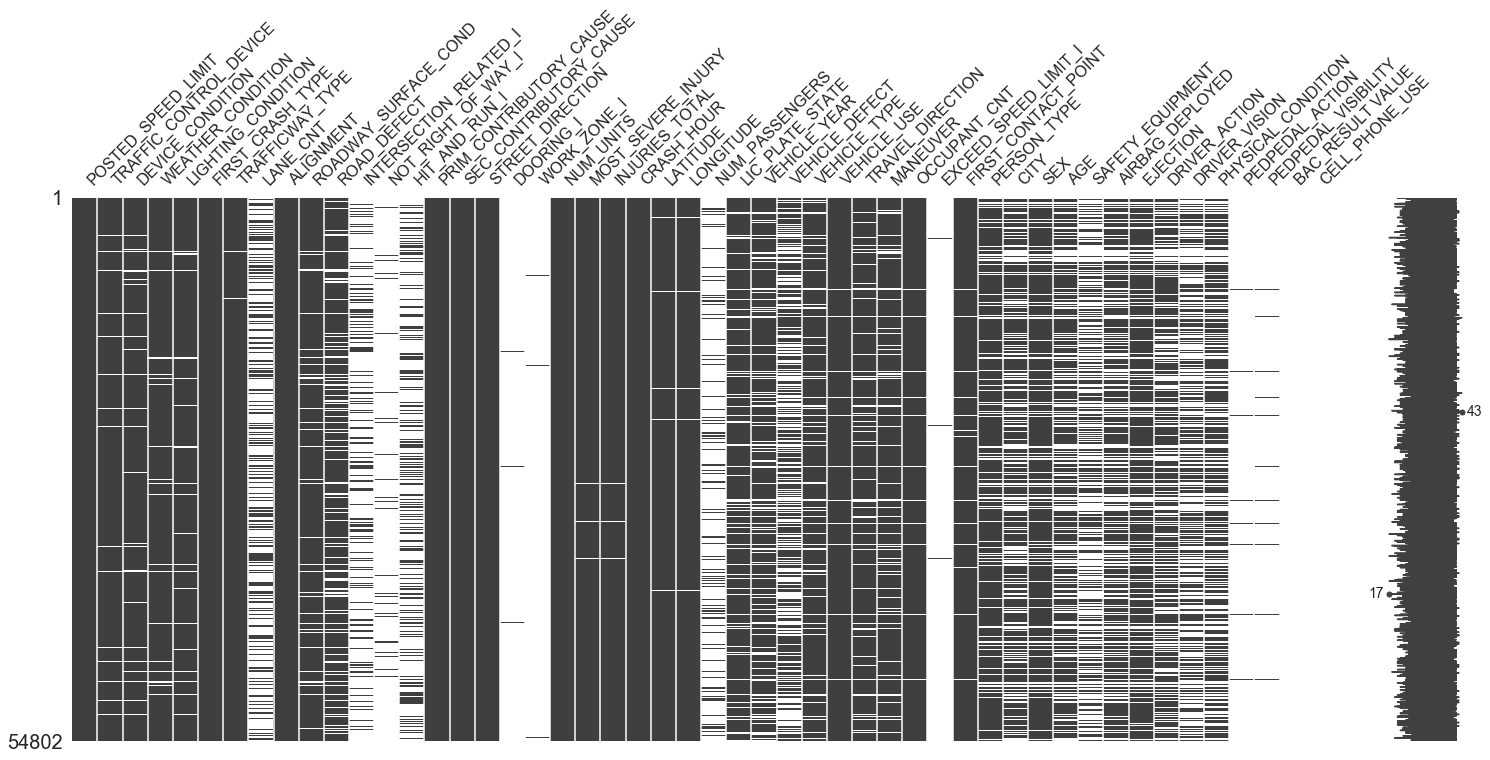

In [21]:
msno.matrix(train)

## Missing value overview on train data

In [22]:
print('\033[1m', 'All 50 columns', '\033[0m')
print('\033[1m', 'These', sum(train.isnull().mean().round(5) > 0.5),
      'columns have > 50% missing values', '\033[0m')
print(train.columns[train.isnull().mean().round(5) > 0.5].tolist())
print('')
raw_null_above50 = train[train.columns[train.isnull().mean().round(5) > 0.5].tolist()]
print(raw_null_above50.isnull().mean().round(5))
print('')
# Subset the data to include the columns only with nulls in the output
train_with_null = train[train.columns[train.isnull().any()].tolist()]
print('\033[1m', 'These', len(train_with_null.columns),
      'columns have any missing values', '\033[0m')
train_with_null.isnull().mean().round(5)

 All 50 columns 
 These 14 columns have > 50% missing values 
['LANE_CNT', 'INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I', 'DOORING_I', 'WORK_ZONE_I', 'NUM_PASSENGERS', 'EXCEED_SPEED_LIMIT_I', 'SAFETY_EQUIPMENT', 'DRIVER_VISION', 'PEDPEDAL_ACTION', 'PEDPEDAL_VISIBILITY', 'BAC_RESULT VALUE', 'CELL_PHONE_USE']

LANE_CNT                  0.67016
INTERSECTION_RELATED_I    0.75691
NOT_RIGHT_OF_WAY_I        0.95883
HIT_AND_RUN_I             0.70238
DOORING_I                 0.99662
WORK_ZONE_I               0.99443
NUM_PASSENGERS            0.84501
EXCEED_SPEED_LIMIT_I      0.99715
SAFETY_EQUIPMENT          0.54288
DRIVER_VISION             0.50527
PEDPEDAL_ACTION           0.97907
PEDPEDAL_VISIBILITY       0.97597
BAC_RESULT VALUE          0.99807
CELL_PHONE_USE            0.99896
dtype: float64

 These 42 columns have any missing values 


TRAFFIC_CONTROL_DEVICE    0.02909
DEVICE_CONDITION          0.05237
WEATHER_CONDITION         0.03834
LIGHTING_CONDITION        0.03212
TRAFFICWAY_TYPE           0.00878
LANE_CNT                  0.67016
ROADWAY_SURFACE_COND      0.06027
ROAD_DEFECT               0.13824
INTERSECTION_RELATED_I    0.75691
NOT_RIGHT_OF_WAY_I        0.95883
HIT_AND_RUN_I             0.70238
DOORING_I                 0.99662
WORK_ZONE_I               0.99443
MOST_SEVERE_INJURY        0.00210
INJURIES_TOTAL            0.00208
LATITUDE                  0.00553
LONGITUDE                 0.00553
NUM_PASSENGERS            0.84501
LIC_PLATE_STATE           0.10591
VEHICLE_YEAR              0.18196
VEHICLE_DEFECT            0.42796
VEHICLE_TYPE              0.11520
VEHICLE_USE               0.02688
TRAVEL_DIRECTION          0.09691
MANEUVER                  0.09945
OCCUPANT_CNT              0.02688
EXCEED_SPEED_LIMIT_I      0.99715
FIRST_CONTACT_POINT       0.03465
PERSON_TYPE               0.13861
CITY          

In [23]:
train["PEDPEDAL_VISIBILITY"].value_counts()

NO CONTRASTING CLOTHING    1061
CONTRASTING CLOTHING        160
OTHER LIGHT SOURCE USED      66
REFLECTIVE MATERIAL          30
Name: PEDPEDAL_VISIBILITY, dtype: int64

In [24]:
# replacing TRAFFIC_CONTROL_DEVICE with No Controls 
# replacing DEVICE_CONDITION with No Controls 

train.fillna({
    'TRAFFIC_CONTROL_DEVICE': 'NO CONTROLS',
    'DEVICE_CONDITION': 'NO CONTROLS',
    'WEATHER_CONDITION': 'CLEAR',
    'LIGHTING_CONDITION': 'DAYLIGHT',
    'TRAFFICWAY_TYPE': 'NOT DIVIDED',
    'ROADWAY_SURFACE_COND': 'NO DEFECTS',
    'ROAD_DEFECT': 'CLEAR',
    'INTERSECTION_RELATED_I': 'N',
    
    'NOT_RIGHT_OF_WAY_I': 'N',
    'HIT_AND_RUN_I': 'N',
    'DOORING_I': 'N',
    'WORK_ZONE_I': 'N',
    'NUM_PASSENGERS': 0,
    'LIC_PLATE_STATE': 'IL',
    'VEHICLE_DEFECT': 'UNABLE TO DETERMINE',
    'VEHICLE_TYPE': 'OTHER',
    
    'VEHICLE_USE': 'OTHER',
    'TRAVEL_DIRECTION': 'N',
    'MANEUVER': 'OTHER',
    'OCCUPANT_CNT': 0,
    'EXCEED_SPEED_LIMIT_I': 'N',
    'FIRST_CONTACT_POINT': 'OTHER',
    'PERSON_TYPE': 'UNABLE TO DETERMINE',
    'CITY': 'OTHER',
    
    'SEX': 'UNABLE TO DETERMINE',
    'AIRBAG_DEPLOYED': 'UNABLE TO DETERMINE',
    'EJECTION': 'UNABLE TO DETERMINE',
    'DRIVER_ACTION': 'OTHER',
    'DRIVER_VISION': 'OTHER',
    'PHYSICAL_CONDITION': 'UNABLE TO DETERMINE',
    'PEDPEDAL_ACTION': 'UNABLE TO DETERMINE',
    'PEDPEDAL_VISIBILITY': 'UNABLE TO DETERMINE',
    
    'CELL_PHONE_USE': 'UNABLE TO DETERMINE',
    'SAFETY_EQUIPMENT': 'UNABLE TO DETERMINE',
    'BAC_RESULT VALUE': 0
}, inplace=True)

In [25]:
train.isnull().sum()

POSTED_SPEED_LIMIT             0
TRAFFIC_CONTROL_DEVICE         0
DEVICE_CONDITION               0
WEATHER_CONDITION              0
LIGHTING_CONDITION             0
FIRST_CRASH_TYPE               0
TRAFFICWAY_TYPE                0
LANE_CNT                   36726
ALIGNMENT                      0
ROADWAY_SURFACE_COND           0
ROAD_DEFECT                    0
INTERSECTION_RELATED_I         0
NOT_RIGHT_OF_WAY_I             0
HIT_AND_RUN_I                  0
PRIM_CONTRIBUTORY_CAUSE        0
SEC_CONTRIBUTORY_CAUSE         0
STREET_DIRECTION               0
DOORING_I                      0
WORK_ZONE_I                    0
NUM_UNITS                      0
MOST_SEVERE_INJURY           115
INJURIES_TOTAL               114
CRASH_HOUR                     0
LATITUDE                     303
LONGITUDE                    303
NUM_PASSENGERS                 0
LIC_PLATE_STATE                0
VEHICLE_YEAR                9972
VEHICLE_DEFECT                 0
VEHICLE_TYPE                   0
VEHICLE_US

| **Feature** | **Description** | **Decision on NA** |
|:----|:----|:-----|
| LANE_CNT | Total number of through lanes in either direction, excluding turn lanes, as determined by reporting officer (0 = intersection) | Replace with mode = 2 |
| INTERSECTION_RELATED_I | A field observation by the police officer whether an intersection played a role in the crash. Does not represent whether or not the crash occurred within the intersection.Y&N | Replace with "N" |
| HIT_AND_RUN_I |  Crash did/did not involve a driver who caused the crash and fled the scene without exchanging information and/or rendering aid Y&N | Replace with "N" |
| INJURIES_TOTAL | Total persons sustaining fatal, incapacitating, non-incapacitating, and possible injuries as determined by the reporting officer | Replace with "0" |
| INJURIES_FATAL | Total persons sustaining fatal injuries in the crash | Replace with "0" |
| INJURIES_INCAPACITATING | Total persons sustaining incapacitating/serious injuries in the crash as determined by the reporting officer. Any injury other than fatal injury, which prevents the injured person from walking, driving, or normally continuing the activities they were capable of performing before the injury occurred. Includes severe lacerations, broken limbs, skull or chest injuries, and abdominal injuries. | Replace with "0" |
| INJURIES_NON_INCAPACITATING | Total persons sustaining no injuries in the crash as determined by the reporting officer | Replace with "0" |
| INJURIES_REPORTED_NOT_EVIDENT | Total persons sustaining possible injuries in the crash as determined by the reporting officer. Includes momentary unconsciousness, claims of injuries not evident, limping, complaint of pain, nausea, and hysteria. | Replace with "0" |
| LOCATION | The crash location, as determined by reporting officer, as derived from the reported address of crash, in a column type that allows for mapping and other geographic analysis in the data portal software | DROP the row |
| NUM_PASSENGERS | Number of passengers in the vehicle. The driver is not included. More information on passengers is in the People dataset. | DROP the column |
| LIC_PLATE_STATE | The state issuing the license plate of the vehicle, if relevant | Replace with "IL" |
| VEHICLE_YEAR | The model year of the vehicle, if relevant | DROP the row |
| VEHICLE_DEFECT | no definition | Replace with "UNKNOWN" |
| VEHICLE_TYPE | The type of vehicle, if relevant | Replace with "UNKNOWN/NA" |
| VEHICLE_USE | The normal use of the vehicle, if relevant | Replace with "UNKNOWN/NA" |
| TRAVEL_DIRECTION | The direction in which the unit was traveling prior to the crash, as determined by the reporting officer | Replace with "UNKNOWN" |
| MANEUVER | The action the unit was taking prior to the crash, as determined by the reporting officer | Replace with "UNKNOWN/NA" |
| OCCUPANT_CNT |The number of people in the unit, as determined by the reporting officer | DROP the row |
| EXCEED_SPEED_LIMIT_I | Indicator of whether the unit was speeding, as determined by the reporting officer | DROP Column |
| FIRST_CONTACT_POINT | No definition | Replace with "UNKNOWN" |
| PERSON_ID | A unique identifier for each person record. IDs starting with P indicate passengers. IDs starting with O indicate a person who was not a passenger in the vehicle (e.g., driver, pedestrian, cyclist, etc.). | DROP the row |
| PERSON_TYPE | Type of roadway user involved in crash | DROP the row |
| SEX | Gender of person involved in crash, as determined by reporting officer | Replace with "X" |
| AGE | Age of person involved in crash | Replace with mean |
| SAFETY_EQUIPMENT | Safety equipment used by vehicle occupant in crash, if any | Replace with "USAGE UNKNOWN" |
| AIRBAG_DEPLOYED | Whether vehicle occupant airbag deployed as result of crash | REplace with "DEPLOYMENT UNKNOWN" |
| EJECTION | Whether vehicle occupant was ejected or extricated from the vehicle as a result of crash | Replace with "UNKNOWN" |
| DRIVER_ACTION | Driver action that contributed to the crash, as determined by reporting officer | Replace with "UNKNOWN" |
| DRIVER_VISION | What, if any, objects obscured the driver’s vision at time of crash| Replace with "UNKNOWN" |
| PHYSICAL_CONDITION | Driver’s apparent physical condition at time of crash, as observed by the reporting officer | Replace with "UNKNOWN" |
| CELL_PHONE_USE | Whether person was/was not using cellphone at the time of the crash, as determined by the reporting officer Y&N | DROP Column |

*Replace columns with 0*
- 1. “INJURIES_TOTAL”: 97 missing data, replace with 0
- 2. “INJURIES_FATAL”: 97 missing data, replace with 0
- 3. “INJURIES_INCAPACITATING”: 97 missing data, replace with 0
- 4. “INJURIES_NON_INCAPACITATING”: 97 missing data, replace with 0
- 5. “INJURIES_REPORTED_NOT_EVIDENT”: 97 missing data, replace with 0

*Replace with meaningful input*
- 1. “LIC_PLATE_STATE”: 4,817 missing data, replace with "IL"
- 2. "SEX": 6406 missing data, replace with "X"
- 3. "SAFETY_EQUIPMENT" : 6,553 missing data, replace with "USAGE UNKNOWN"
- 4. "AIRBAG_DEPLOYED" : 7,470 missing data, replace with "DEPLOYMENT UNKNOWN"

*Replace with frequency (mode):*
- 1. “LANE_CNT”: 30,763 missing data. Replace them with mode “2”

*Replace with "N" to keep it binary:*
- 1. “INTERSECTION_RELATED_I”: 34,718 missing data
- 2. “HIT_AND_RUN_I”: 32,242 missing data


*Replace with "UNKNOWN":*
- 1. "VEHICLE_DEFECT": 1,225 missing data
- 2. "TRAVEL_DIRECTION" : 1,225 missing data
- 3. "FIRST_CONTACT_POINT" : 1,570 missing data
- 4. "EJECTION" : 7,138 missing data
- 5. "DRIVER_ACTION" : 6,511 missing data
- 6. "DRIVER_VISION" : 6,518 missing data
- 7. "PHYSICAL_CONDITION" : 6,466 missing data

*Replace with "UNKNOWN/NA":*
- 1. “VEHICLE_TYPE”: 1,225 missing data
- 2. "VEHICLE_USE": 1,225 missing data
- 3. "MANEUVER" : 1,225 missing data

*Replace with Mean:*
- 1. "AGE" : 16,073 missing data

*Replace with mode/median:*
- 1. "VEHICLE_YEAR" : 8,329 missing data 
- 2. "OCCUPANT_CNT" : 1,225 missing data

*Drop the missing row:*
- 1. "LOCATION" : 249 missing data
- 2. "PERSON_TYPE" : 6.371 missing data
- 3. "MOST_SEVERE_INJURY" : 115 missing data (target feature)

*Drop the column:*
- 1. "NUM_PASSENGERS" : 38,788 missing data
- 2. "CELL_PHONE_USE" : 45,848 missing data
- 3. "EXCEED_SPEED_LIMIT_I" : 45,757 missing data
- 4. "PERSON_ID" : 6,371 missing data (not useful)

### Adjust in dataset

#### Replace by 0

#### Replace with meaningful input

#### Replace with frequency (mode):
“LANE_CNT”: 30,763 missing data. Replace them with mode “2”

In [26]:
train['LANE_CNT'].fillna("2",inplace=True)

In [27]:
print("Total NAs in LANE_CNT")
train['LANE_CNT'].isnull().sum()

Total NAs in LANE_CNT


0

#### Replace by "N" to keep it binary

#### Replace with "OTHER" or "UNKNOWN" or  "UNKNOWN/NA":

In [28]:
print("Total NAs in MANEUVER")
train['MANEUVER'].isnull().sum()

Total NAs in MANEUVER


0

#### Replace with median

In [29]:
train["AGE"] = pd.to_numeric(train["AGE"])
train['AGE'].fillna((train['AGE'].median()), inplace=True)
print("TOTAL NAs in AGE")
train['AGE'].isnull().sum()

TOTAL NAs in AGE


0

In [30]:
train.isnull().sum()

POSTED_SPEED_LIMIT            0
TRAFFIC_CONTROL_DEVICE        0
DEVICE_CONDITION              0
WEATHER_CONDITION             0
LIGHTING_CONDITION            0
FIRST_CRASH_TYPE              0
TRAFFICWAY_TYPE               0
LANE_CNT                      0
ALIGNMENT                     0
ROADWAY_SURFACE_COND          0
ROAD_DEFECT                   0
INTERSECTION_RELATED_I        0
NOT_RIGHT_OF_WAY_I            0
HIT_AND_RUN_I                 0
PRIM_CONTRIBUTORY_CAUSE       0
SEC_CONTRIBUTORY_CAUSE        0
STREET_DIRECTION              0
DOORING_I                     0
WORK_ZONE_I                   0
NUM_UNITS                     0
MOST_SEVERE_INJURY          115
INJURIES_TOTAL              114
CRASH_HOUR                    0
LATITUDE                    303
LONGITUDE                   303
NUM_PASSENGERS                0
LIC_PLATE_STATE               0
VEHICLE_YEAR               9972
VEHICLE_DEFECT                0
VEHICLE_TYPE                  0
VEHICLE_USE                   0
TRAVEL_D

#### Replace with mode/median

In [31]:
train['VEHICLE_YEAR'].fillna(train['VEHICLE_YEAR'].mode()[0], inplace=True)

train["OCCUPANT_CNT"] = pd.to_numeric(train["OCCUPANT_CNT"])
train['OCCUPANT_CNT'].fillna((train['OCCUPANT_CNT'].median()), inplace=True)

print("TOTAL NAs in VEHICLE_YEAR")
train['VEHICLE_YEAR'].isnull().sum()

TOTAL NAs in VEHICLE_YEAR


0

#### Drop the missing row


In [32]:
drop_rows = ['INJURIES_TOTAL', 'LATITUDE','MOST_SEVERE_INJURY']
train.dropna(how='any', subset=drop_rows, inplace = True)
train.isnull().sum()

POSTED_SPEED_LIMIT         0
TRAFFIC_CONTROL_DEVICE     0
DEVICE_CONDITION           0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
FIRST_CRASH_TYPE           0
TRAFFICWAY_TYPE            0
LANE_CNT                   0
ALIGNMENT                  0
ROADWAY_SURFACE_COND       0
ROAD_DEFECT                0
INTERSECTION_RELATED_I     0
NOT_RIGHT_OF_WAY_I         0
HIT_AND_RUN_I              0
PRIM_CONTRIBUTORY_CAUSE    0
SEC_CONTRIBUTORY_CAUSE     0
STREET_DIRECTION           0
DOORING_I                  0
WORK_ZONE_I                0
NUM_UNITS                  0
MOST_SEVERE_INJURY         0
INJURIES_TOTAL             0
CRASH_HOUR                 0
LATITUDE                   0
LONGITUDE                  0
NUM_PASSENGERS             0
LIC_PLATE_STATE            0
VEHICLE_YEAR               0
VEHICLE_DEFECT             0
VEHICLE_TYPE               0
VEHICLE_USE                0
TRAVEL_DIRECTION           0
MANEUVER                   0
OCCUPANT_CNT               0
EXCEED_SPEED_L

In [33]:
train.shape

(54388, 50)

<a id='2.1.3.1'></a>
#### Features that can be imputed/encoded

# Handling Outliers 

##  Categorical Features

Example 1: A, B, C, X.

Example 2: Apple, Orange, Pear or Blueberry, Raspberry, Strawberry, Grape.

"*The fact is **no outlier** exists in the examples above, for an outlier to exist there must be **a measure of distance**. This is intrinsic to numeric data types because there is a Euclidean distance between numbers.*"

**Categorical Outliers don’t exist without a context.**

> "*Techniques like **string indexing** or **one-hot encoding** on a categorical value to convert it from a string value to a numeric value and then use k-means clustering to find outliers.*"

> "*the numeric vector assigned to the String value during the one hot encoding practice still lacks **the domain context**. It does satisfy the input constraint of the k-means model and the model will produce an output. However the output will not select the appropriate outlier, as the input **was not truly valid**.*"

> "*There is an alternative. **K-modes** is designed to handle categorical values without the need for String Indexing or One Hot Encoding.*"

##  Numerical Features

**`LANE_CNT`**

**Outlier Identification**

- 3 rows of 9
- 13 rows of 10
- 1 row of 11
- 4 rows of 12
- 2 rows of 99

According to Chicago's roadway, 6 should be a maximum number for lanes

**Decision** to replace outlier with 6 lanes

In [55]:
train['LANE_CNT']=pd.to_numeric(train['LANE_CNT'])
train['VEHICLE_YEAR']=pd.to_numeric(train['VEHICLE_YEAR'])

In [39]:
# Change all rows with value greater than 6 to 6
train.loc[(train['LANE_CNT'] > 6),'LANE_CNT'] = 6
train['LANE_CNT'].value_counts()

2    44921
4     4408
1     2970
3      769
6      575
0      543
5      202
Name: LANE_CNT, dtype: int64

**No Further Outliers according to the observation**

- `NUM_UNITS`; varies from 1 to 12
- `INJURIES_TOTAL`; varies from 0 to 8
- `INJURIES_FATAL`; varies from 0 to 2
- `INJURIES_INCAPACITATING`; varies from 0 to 5
- `NUM_PASSENGERS`; varies from 1 to 38
- `OCCUPANT_CNT`; varies from 0 to 39
- `AGE`; varies from ... to 101




# Feature Engineering

##  Target Feature Engineering

Pick **`INJURIES_TOTAL`** as a numerical target and/or encode **`INJURY`** as a categorical target.

- `INJURY`: Total persons sustaining **fatal, incapacitating, non-incapacitating** as determined by the reporting officer.

13% Injuries, 87% Non-injuries

Removing NAs from INJURIES_TOTAL below

In [40]:
train["MOST_SEVERE_INJURY"].unique()

array(['NO INDICATION OF INJURY', 'NONINCAPACITATING INJURY',
       'INCAPACITATING INJURY', 'REPORTED, NOT EVIDENT', 'FATAL'],
      dtype=object)

In [41]:
def injury(x): 
    if any(s in x for s in ["FATAL","NONINCAPACITATING INJURY","INCAPACITATING INJURY"]):
        return "INJURED"
    else:
        return "NOT INJURED"
    
# replacing NA values with OTHER
train["INJURY"] = train["MOST_SEVERE_INJURY"].apply(lambda x: injury(x))
train.drop("MOST_SEVERE_INJURY", axis=1, inplace=True)

In [42]:
train["INJURY"].value_counts()

NOT INJURED    48496
INJURED         5892
Name: INJURY, dtype: int64

##  Other Feature Engineering / Adaptation

### CONTACT_POINT

Reduced # of layers in `FIRST_CONTACT_POINT` to:
- FRONT
- SIDE
- READ
- OTHER

In [43]:
def contact_point(x):
    if "FRONT" in x:
        return "FRONT"
    elif "SIDE" in x:
        return "SIDE"
    elif "REAR" in x:
        return "REAR"
    else:
        return "OTHER"
    
# replacing NA values with OTHER
train["FIRST_CONTACT_POINT"] = train["FIRST_CONTACT_POINT"].apply(lambda x: contact_point(x))

In [44]:
train["MANEUVER"].unique()

array(['STRAIGHT AHEAD', 'CHANGING LANES', 'TURNING LEFT',
       'TURNING RIGHT', 'PARKED', 'MERGING', 'SLOW/STOP IN TRAFFIC',
       'OTHER', 'ENTERING TRAFFIC LANE FROM PARKING',
       'PASSING/OVERTAKING', 'LEAVING TRAFFIC LANE TO PARK', 'BACKING',
       'STARTING IN TRAFFIC', 'SKIDDING/CONTROL LOSS',
       'SLOW/STOP - LEFT TURN', 'SLOW/STOP - RIGHT TURN',
       'PARKED IN TRAFFIC LANE', 'AVOIDING VEHICLES/OBJECTS',
       'SLOW/STOP - LOAD/UNLOAD', 'ENTER FROM DRIVE/ALLEY',
       'TURNING ON RED', 'DRIVING WRONG WAY', 'U-TURN',
       'NEGOTIATING A CURVE', 'DISABLED', 'DRIVERLESS', 'DIVERGING'],
      dtype=object)

### MANEUVER, VEHICLE_YEAR, POSTED_SPEED_LIMIT

Reduced # of layers in `MANEUVER` to:
- UNKNOWN/NA
- TURN
- LANE
- OTHER

Reduced # layers in `VEHICLE_YEAR` to:
- NEW
- OLD (<2010)
- UNKNOWN

Reduced # layers in `POSTED_SPEED_LIMIT` to:
- LOW_SPEED (< 30mph)
- HIGH_SPEED

In [45]:
# merging same type of Maneuver in one
train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "TURN" if "TURN" in x else("LANE" if any(s in x for s in ["LANE","OVER","ENTER"]) else x))
train["MANEUVER"] = train["MANEUVER"].apply(lambda x: "OTHER" if all(s not in x for s in ["AHEAD","TURN","UNKNOWN","LANE","BACKING"]) else x)

# converting VEHICLE_YEAR into new category of OLD or NEW
#train["VEHICLE_YEAR"]= train["VEHICLE_YEAR"].apply(lambda x: "UNKNOWN" if pd.isnull(x) else ("OLD (<2010)" if int(x)<2010 else "NEW"))

# converting POSTED_SPEED_LIMIT into new category of LOW SPEED or HIGH SPEED
#train["POSTED_SPEED_LIMIT"]=train["POSTED_SPEED_LIMIT"].apply(lambda x: "LOW_SPEED" if int(x)<=30 else "HIGH_SPEED")

### SAFETY_EQUIPMENT, AIRBAG_DEPLOYED

Reduced # of layers in `SAFETY_EQUIPMENT` to:
- USED SAFETY EQUIPMENT
- DID NOT USE SAFETY EQUIPMENT

Reduced # of layers in `AIRBAG_DEPLOYED` to:
- DEPLOYED
- NOT DEPLOYED

In [46]:
# grouping the SAFETY_EQUIPMENT used as SAFE and UNSAFE
def equip_used(x):
    if ("USED" in x) or ("HELMET" in x) or ("NONE PRESENT" in x):
        if any(s in x for s in ["NOT","IMPROPER","NONE PRESENT"]):
            return "DID NOT USE SAFETY EQUIP"
        else:
            return "USED SAFETY EQUIP"
    else:
        return x

train["SAFETY_EQUIPMENT"]= train["SAFETY_EQUIPMENT"].apply(lambda x: equip_used(x))


# grouping the AIRBAG_DEPLOYED used as DEPLOYED and NOT DEPLOYED
def airbag(x):
    if ("DEPLOY" in x) and ("UNKNOWN" not in x):
        if "NOT" in x:
            return "NOT DEPLOYED"
        else:
            return "DEPLOYED"
    else:
        return x
 
train["AIRBAG_DEPLOYED"]= train["AIRBAG_DEPLOYED"].apply(lambda x: airbag(x))

### CRASH_HOUR

Transform the crash hour to 4 categories:
- Early morning
- Morning
- Afternoon
- Night

In [47]:
def crash_hour(x):
    if  2 <= x < 8:
        return "Early_morning"
    elif 8 <= x < 12:
        return "Morning"
    elif 12 <= x < 18:
        return "Afternoon"
    else:
        return "Night"
    
# replacing NA values with OTHER
train["CRASH_HOUR"] = train["CRASH_HOUR"].apply(lambda x: crash_hour(int(x)))

### TRAFFIC_CONTROL_DEVICE

Transform the signs
- 'TRAFFIC SIGNAL', 'STOP SIGN/FLASHER', 'LANE USE MARKING', 'YIELD', 'DELINEATORS', 
'OTHER REG. SIGN', 'OTHER WARNING SIGN', 'POLICE/FLAGMAN', 'RAILROAD CROSSING GATE', 
'OTHER RAILROAD CROSSING', 'FLASHING CONTROL SIGNAL', 'PEDESTRIAN CROSSING SIGN',
'NO PASSING', 'SCHOOL ZONE', 'BICYCLE CROSSING SIGN' as `SIGN`
    
- 'NO CONTROLS','UNKNOWN', 'OTHER' as `NO_SIGN`

In [48]:
def traffic_control(x):
    if ("NO CONTROLS" in x) or ("UNKNOWN" in x) or ("OTHER" in x):
        return "NO_SIGN"
    else:
        return "SIGN"

train["TRAFFIC_CONTROL_DEVICE"]= train["TRAFFIC_CONTROL_DEVICE"].apply(lambda x: traffic_control(x))

In [49]:
def location(x1,x2):
    if (41.875297 <= float(x1) <= 41.9000064) and (-87.6321459 <= float(x2) <= -87.6096752):
        return "Downtown"
    else:
        return "Not Downtown"

#df['col_3'] = df.apply(lambda x: f(x.col_1, x.col_2), axis=1)
train["Location"] = train.apply(lambda x: location(x["LATITUDE"],x["LONGITUDE"]), axis=1)

In [50]:
train["Location"].unique()

array(['Downtown', 'Not Downtown'], dtype=object)

In [51]:
train.isnull().sum()

POSTED_SPEED_LIMIT         0
TRAFFIC_CONTROL_DEVICE     0
DEVICE_CONDITION           0
WEATHER_CONDITION          0
LIGHTING_CONDITION         0
FIRST_CRASH_TYPE           0
TRAFFICWAY_TYPE            0
LANE_CNT                   0
ALIGNMENT                  0
ROADWAY_SURFACE_COND       0
ROAD_DEFECT                0
INTERSECTION_RELATED_I     0
NOT_RIGHT_OF_WAY_I         0
HIT_AND_RUN_I              0
PRIM_CONTRIBUTORY_CAUSE    0
SEC_CONTRIBUTORY_CAUSE     0
STREET_DIRECTION           0
DOORING_I                  0
WORK_ZONE_I                0
NUM_UNITS                  0
INJURIES_TOTAL             0
CRASH_HOUR                 0
LATITUDE                   0
LONGITUDE                  0
NUM_PASSENGERS             0
LIC_PLATE_STATE            0
VEHICLE_YEAR               0
VEHICLE_DEFECT             0
VEHICLE_TYPE               0
VEHICLE_USE                0
TRAVEL_DIRECTION           0
MANEUVER                   0
OCCUPANT_CNT               0
EXCEED_SPEED_LIMIT_I       0
FIRST_CONTACT_

# Baseline Model

In [ ]:
# removing below columns
drop_list=["LATITUDE","LONGITUDE","INJURIES_TOTAL"]

train_new = train.drop(drop_list, axis=1)

In [142]:
# splitting the dataset into x_train and y_train
X_train = train_new.drop(["INJURY"],axis=1)
y_train = train_new["INJURY"]

In [143]:
# performing one hot encoding on all the object features
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns, drop_first=True)

In [144]:
X_train.head()

LANE_CNT  NUM_UNITS  OCCUPANT_CNT   AGE  POSTED_SPEED_LIMIT_1  \
29244         4          2             1  26.0                     0   
22376         3          2             1  51.0                     0   
49790         2          1             1  73.0                     0   
32552         2          2             1  38.0                     0   
1957          2          2             1  30.0                     0   

       POSTED_SPEED_LIMIT_10  POSTED_SPEED_LIMIT_11  POSTED_SPEED_LIMIT_15  \
29244                      0                      0                      0   
22376                      0                      0                      0   
49790                      0                      0                      0   
32552                      0                      0                      0   
1957                       0                      0                      0   

       POSTED_SPEED_LIMIT_2  POSTED_SPEED_LIMIT_20  POSTED_SPEED_LIMIT_24  \
29244                     0                      0                      0   
22376                     0                      0                      0   
49790                     0                      0                      0   
32552                     0                      0                      0   
1957                      0                      0                      0   

       POSTED_SPEED_LIMIT_25  POSTED_SPEED_LIMIT_3  POSTED_SPEED_LIMIT_30  \
29244                      0                     0                      1   
22376                      0                     0                      1   
49790                      0                     0                      1   
32552                      0                     0                      1   
1957                       0                     0                      1   

       POSTED_SPEED_LIMIT_32  POSTED_SPEED_LIMIT_33  POSTED_SPEED_LIMIT_35  \
29244                      0                      0                      0   
22376                      0                      0                      0   
49790                      0                      0                      0   
32552                      0                      0                      0   
1957                       0                      0                      0   

       POSTED_SPEED_LIMIT_39  POSTED_SPEED_LIMIT_4  POSTED_SPEED_LIMIT_40  \
29244                      0                     0                      0   
22376                      0                     0                      0   
49790                      0                     0                      0   
32552                      0                     0                      0   
1957                       0                     0                      0   

       POSTED_SPEED_LIMIT_45  POSTED_SPEED_LIMIT_5  POSTED_SPEED_LIMIT_50  \
29244                      0                     0                      0   
22376                      0                     0                      0   
49790                      0                     0                      0   
32552                      0                     0                      0   
1957                       0                     0                      0   

       POSTED_SPEED_LIMIT_55  POSTED_SPEED_LIMIT_60  POSTED_SPEED_LIMIT_65  \
29244                      0                      0                      0   
22376                      0                      0                      0   
49790                      0                      0                      0   
32552                      0                      0                      0   
1957                       0                      0                      0   

       POSTED_SPEED_LIMIT_70  POSTED_SPEED_LIMIT_9  \
29244                      0                     0   
22376                      0                     0   
49790                      0                     0   
32552                      0                     0   
1957                       0                 

In [145]:
#Encode the y_train labels
lb = preprocessing.LabelBinarizer()
y_train=lb.fit_transform(y_train)

In [146]:
#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print('Accuracy', np.mean(scores), scores)

Accuracy 0.9077186270595693 [0.91009377 0.90669241 0.90568119 0.90695964 0.90916613]


In [139]:
recall = cross_val_score(clf, X_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(clf, X_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.9903497055175207 [0.99103093 0.98907104 0.98834931 0.99278276 0.99051449]
Precision 0.9457140235432522 [0.9491157  0.94521628 0.94876867 0.94120524 0.94426423]
F1 0.9666481972352574 [0.96909192 0.9659028  0.96474134 0.96648746 0.96701747]


[0.01145511 0.0232193  0.01314021 ... 0.00032217 0.00014396 0.00245131]


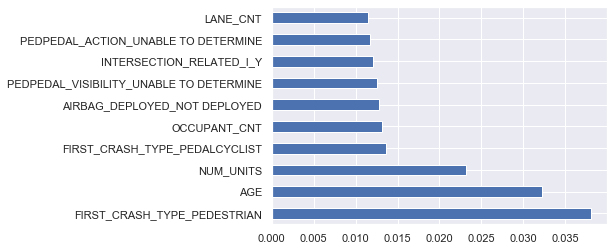

In [147]:
#Create a Random Forest Classifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
print(clf.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [151]:
feat_importances.nlargest(50)

FIRST_CRASH_TYPE_PEDESTRIAN                              0.038008
AGE                                                      0.032180
NUM_UNITS                                                0.023219
FIRST_CRASH_TYPE_PEDALCYCLIST                            0.013623
OCCUPANT_CNT                                             0.013140
AIRBAG_DEPLOYED_NOT DEPLOYED                             0.012794
PEDPEDAL_VISIBILITY_UNABLE TO DETERMINE                  0.012600
INTERSECTION_RELATED_I_Y                                 0.012051
PEDPEDAL_ACTION_UNABLE TO DETERMINE                      0.011709
LANE_CNT                                                 0.011455
SEX_M                                                    0.010679
TRAFFICWAY_TYPE_NOT DIVIDED                              0.010589
STREET_DIRECTION_W                                       0.010550
SEC_CONTRIBUTORY_CAUSE_NOT APPLICABLE                    0.010400
STREET_DIRECTION_S                                       0.010216
FIRST_CONT

## Decision Tree

Filtering out the most important variables identified by Random Forest

In [97]:
train["POSTED_SPEED_LIMIT"]=pd.to_numeric(train["POSTED_SPEED_LIMIT"])

In [98]:
filter_list=["FIRST_CRASH_TYPE","AGE","AIRBAG_DEPLOYED","INTERSECTION_RELATED_I","LANE_CNT","SEX",
             "TRAFFICWAY_TYPE","POSTED_SPEED_LIMIT","CRASH_HOUR","VEHICLE_YEAR","FIRST_CRASH_TYPE","INJURY"]

train_new = train[filter_list]

In [99]:
# splitting the dataset into x_train and y_train
X_train = train_new.drop(["INJURY"],axis=1)
y_train = train_new["INJURY"]

In [100]:
# performing one hot encoding on all the object features
X_train = pd.get_dummies(X_train, columns=X_train.select_dtypes(['object']).columns, drop_first=True)

In [88]:
#Encode the y_train labels
lb = preprocessing.LabelBinarizer()
y_train=lb.fit_transform(y_train)

In [101]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=10)

In [68]:
recall = cross_val_score(dt_default, X_train, y_train, cv=5, scoring='recall')
print('Recall', np.mean(recall), recall)
precision = cross_val_score(dt_default, X_train, y_train, cv=5, scoring='precision')
print('Precision', np.mean(precision), precision)
f1 = cross_val_score(dt_default, X_train, y_train, cv=5, scoring='f1')
print('F1', np.mean(f1), f1)

Recall 0.9765342117318928 [0.97340206 0.98319414 0.96783174 0.97690484 0.98133828]
Precision 0.9224314248787872 [0.92993693 0.9151957  0.92657653 0.92061796 0.91983   ]
F1 0.9487771333107012 [0.95108066 0.94810617 0.94665188 0.94822152 0.94982544]


### Graphviz

Python requires library pydot and an external software graphviz to visualize the decision tree. If you are on wondows, you'll need to specify the path for the pydot library to access dot file from graphviz.

Please read the downloadable instructions to install graphviz. For Mac users, one way is to:

Install the python graphviz module: pip install graphviz
Then install the Graphviz software on Mac, you do this using homebrew:
Install homebrew: https://docs.brew.sh/Installation
brew install graphviz

In [102]:
# Importing required packages for visualization
from IPython.display import Image 
from io import StringIO
#from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
#import pydotplus

# Putting features
features = list(train_new.columns[1:])
features

['AGE',
 'AIRBAG_DEPLOYED',
 'INTERSECTION_RELATED_I',
 'LANE_CNT',
 'SEX',
 'TRAFFICWAY_TYPE',
 'POSTED_SPEED_LIMIT',
 'CRASH_HOUR',
 'VEHICLE_YEAR',
 'FIRST_CRASH_TYPE',
 'INJURY']

In [103]:
dt_default.fit(X_train,y_train)
export_graphviz(dt_default,
                     out_file="tree.dot",
                     filled=True,rounded=True)